In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd

from scipy.special import logsumexp


In [11]:
perform_computation = True
data_file = f'./docword.nips.txt'

with open(data_file) as fh:
    for line_num, line in enumerate(fh):
        if line_num == 0:
            N = int(line) # Number of documents
        elif line_num == 1:
            d = int(line) # Number of words
            X = np.zeros((N, d))
        elif line_num == 2:
            NNZ = int(line)
        else:
            doc_id, word_id, count = tuple([int(a) for a in line.split(' ')])
            X[doc_id-1, word_id-1] = count

assert X[X>0].size == NNZ

In [12]:
with open('./vocab.nips.txt') as fh2:
    words = [line.rstrip() for line in fh2]

assert len(words) == d

In [4]:
def find_logW(X, log_P, log_pi):
    """
    Compute the weights W from the E step of expectation maximization.

        Parameters:
                X (np.array): A numpy array of the shape (N,d) where N is the number of documents and d is the number of words.
                log_P (np.array): A numpy array of the shape (t,d) where t is the number of topics for clustering and d is the number of words.
                log_pi (np.array): A numpy array of the shape (t,1) where t is the number of topics for clustering.

        Returns:
                log_W (np.array): A numpy array of the shape (N,t) where N is the number of documents and t is the number of topics for clustering.
    """
    N, d = X.shape
    t = log_pi.shape[0]

    # your code here
    R_ = (np.ones((N, 1)) @ log_pi.T) + (X @ log_P.T)
    S_ = logsumexp(R_, axis=1, keepdims=True)
    log_W = R_ - S_

    assert log_W.shape == (N, t)
    return log_W

some_X = 1 + (np.arange(35, dtype='int64').reshape(7,5) ** 13) % 20
some_log_P = np.log(some_X[:3, :]/np.sum(some_X[:3, :], axis=1).reshape(-1,1))
some_log_pi = np.log(some_X[:3, 0]/np.sum(some_X[:3, 0])).reshape(-1,1)
some_log_W = find_logW(some_X, some_log_P, some_log_pi)

assert np.array_equal(some_log_W.round(2), np.array([[ -0.  ,  -9.07,  -6.1 ],
                                                     [-24.61,  -0.  , -12.27],
                                                     [-12.59,  -6.01,  -0.  ],
                                                     [-23.81,  -0.  , -29.1 ],
                                                     [ -0.  ,  -9.07,  -6.1 ],
                                                     [-24.61,  -0.  , -14.62],
                                                     [-29.96,  -0.  , -10.82]]))

In [5]:
def update_logP(X, log_W, eps=1e-100):
    """
    Compute the parameters log(P) from the M step of expectation maximization.

        Parameters:
                X (np.array): A numpy array of the shape (N,d) where N is the number of documents and d is the number of words.
                log_W (np.array): A numpy array of the shape (N,t) where N is the number of documents and t is the number of topics for clustering.

        Returns:
                log_P (np.array): A numpy array of the shape (t,d) where t is the number of topics for clustering and d is the number of words.
    """
    N, d = X.shape
    t = log_W.shape[1]
    assert log_W.shape[0] == N

    # your code here
    W = np.exp(log_W)
    E_ = np.log(W.T @ X + eps)
    F_ = logsumexp(E_, axis=1, keepdims=True)
    log_P = E_ - F_

    assert log_P.shape == (t, d)
    return log_P

some_X = 1 + (np.arange(35, dtype='int64').reshape(7,5) ** 13) % 20
some_log_P = np.log(some_X[:3, :]/np.sum(some_X[:3, :], axis=1).reshape(-1,1))
some_log_pi = np.log(some_X[:3, 0]/np.sum(some_X[:3, 0])).reshape(-1,1)
some_log_W = find_logW(some_X, some_log_P, some_log_pi)

assert np.array_equal(update_logP(some_X, some_log_W, eps=1e-100).round(2), np.array([[-3.22, -2.53, -0.65, -1.83, -1.61],
                                                                                      [-1.87, -1.16, -1.81, -1.86, -1.55],
                                                                                      [-3.8 , -1.32, -1.24, -1.17, -2.2 ]]))

In [9]:
def update_log_pi(log_W):
    """
    Compute the prior pi from the M step of expectation maximization.

        Parameters:
                log_W (np.array): A numpy array of the shape (N,t) where N is the number of documents and t is the number of topics for clustering.

        Returns:
                log_pi (np.array): A numpy array of the shape (t,1) where t is the number of topics for clustering.
    """
    N, t = log_W.shape

    # your code here
    log_pi = logsumexp(log_W.T, axis=1, keepdims=True) - np.log(N)

    assert log_pi.shape == (t,1)
    return log_pi

some_X = 1 + (np.arange(35, dtype='int64').reshape(7,5) ** 13) % 20
some_log_P = np.log(some_X[:3, :]/np.sum(some_X[:3, :], axis=1).reshape(-1,1))
some_log_pi = np.log(some_X[:3, 0]/np.sum(some_X[:3, 0])).reshape(-1,1)
some_log_W = find_logW(some_X, some_log_P, some_log_pi)

assert np.array_equal(update_log_pi(some_log_W).round(2), np.array([[-1.26],
                                                                    [-0.56],
                                                                    [-1.94]]))

In [10]:
def TopicModel(X, t, iterations=100, seed=12345):
    N, d = X.shape

    np_random = np.random.RandomState(seed=seed)
    pi_init = np.ones((t,1))/float(t)

    if True:
        P_init = np_random.uniform(0, 1, (t, d))
    else:
        X_copy = X.copy()
        np_random.shuffle(X_copy)

        c = N//t
        P_init = np.zeros((t, d))
        for k in range(t):
            P_init[k, :] = (X_copy[(c*k):(c*(k+1)), :]).sum(axis=0) + 1e-1

    P_init = P_init/P_init.sum(axis=1).reshape(-1, 1)

    log_pi = np.log(pi_init) # log_pi.shape == (t,1)
    log_P = np.log(P_init) # log_P.shape == (t,d)
    assert log_pi.shape == (t,1)

    log_W = None
    for iteration in range(iterations):
        print('.', end='')
        #The E-Step
        log_W = find_logW(X, log_P, log_pi)

        #The M-Step
        log_P = update_logP(X, log_W)
        log_pi = update_log_pi(log_W)

    return log_pi, log_P, log_W

In [13]:
if perform_computation:
    log_pi, log_P, log_W = TopicModel(X, t=30, iterations=100, seed=12345)


....................................................................................................

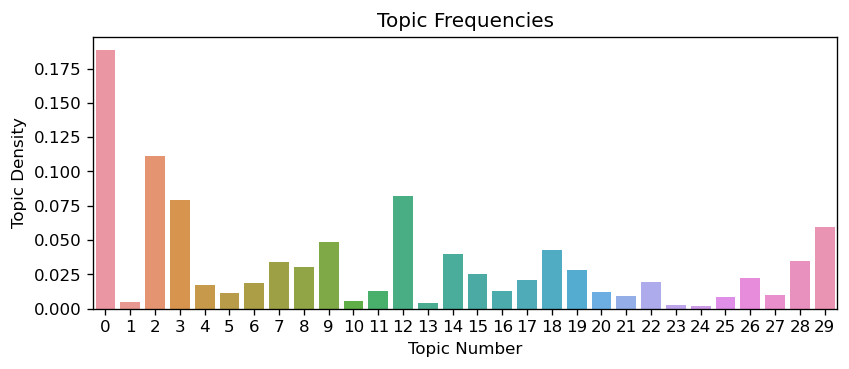

In [15]:
if perform_computation:
    fig, ax=plt.subplots(figsize=(8,3), dpi=120)
    a = np.exp(log_pi)
    sns.barplot(x=np.arange(30), y=np.exp(log_pi).reshape(-1), ax=ax)
    ax.set_title(f'Topic Frequencies')
    ax.set_xlabel(f'Topic Number')
    _ = ax.set_ylabel(f'Topic Density')